In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder

In [8]:
# Initialise
x_train = pd.read_csv('../output/dataset/census2/x_train.csv')
x1_name = 'age'
x2_name = 'hours_per_week'
tuner = 2

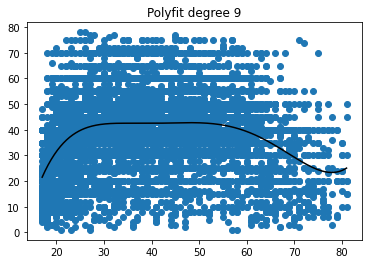

[ 1.17876797e-06 -2.93146740e-04  2.80261763e-02 -1.29812686e+00
  2.92954422e+01 -2.16204938e+02]


In [9]:
# Find Equation
X = x_train[x1_name]
y = x_train[x2_name]
X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)
coefs = np.polyfit(X.values.flatten(), y.values.flatten(), 5)
plt.figure()
plt.plot(X_seq, np.polyval(coefs, X_seq), color="black")
plt.title("Polyfit degree "+str(9))
plt.scatter(X,y)
plt.show()
print(coefs)

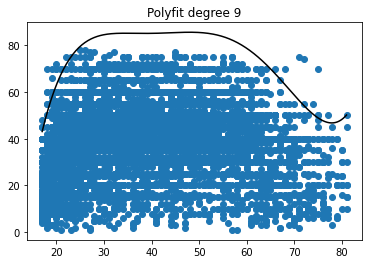

[71.65533538 81.14735005 84.99060624 ... 79.523586   85.1079706
 71.65533538]


In [10]:
# Tune your equation
coefs_new = np.copy(coefs)
coefs_new *= tuner
plt.figure()
plt.plot(X_seq, np.polyval(coefs_new, X_seq), color="black")
plt.title("Polyfit degree "+str(9))
plt.scatter(X,y)
plt.show()
print(np.polyval(coefs_new, X))

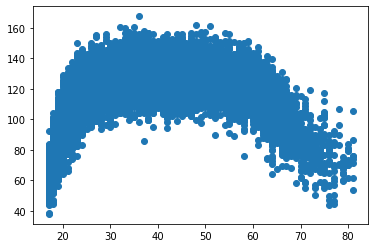

In [11]:
# Creating new x
# Getting std for specific x
def std(X_, x1, x_name=x1_name, y_name=x2_name):
    X__ = X_[X_[x_name] == x1]
    mu = np.mean(X__)
    sigma = np.std(X__)
    return mu[y_name], sigma[y_name]
y_new = []
for i in X:
    mu, sigma = std(x_train, i)
    noise = np.random.normal(mu, sigma, 1)[0]
    y_new.append(np.polyval(coefs_new, i) + noise)
plt.scatter(X,y_new)
plt.show()

In [12]:
# Test Accuracy on Original vs Imputed
model_name = 'autoencode'
data_path = 'clf_autoencoder_2'
my_file = "../output/model/census2/encoder_torch.joblib"
clf = load(my_file)
# print(x_train.head())
x_new_1 = x_train.to_numpy()
print(x_new_1.shape)
print(clf.predict_proba(x_new_1))
y_test_scores1 = clf.predict(x_new_1)
unique1, counts1 = np.unique(y_test_scores1, return_counts=True)
test1 = dict(zip(unique1, counts1))
print("Test acc original: ", test1[0] / len(y_test_scores1))
print(y_test_scores1, counts1)

# Replace column with y_new
y_new = np.array(y_new)
x_train_anomalous = x_train.copy()
x_train_anomalous[x2_name] = y_new
# print(x_train.head())
x_new_2 = x_train_anomalous.to_numpy()
np.savetxt('age_hpw_anomaly.txt', x_new_2, fmt='%d')
y_test_scores2 = clf.predict(x_new_2)
print(clf.predict_proba(x_new_2))
unique2, counts2 = np.unique(y_test_scores2, return_counts=True)
test2 = dict(zip(unique2, counts2))
print("Test acc new: ", test2[0] / len(y_test_scores2))
print(y_test_scores2, counts2)

/home/saif/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


(20706, 10)
[[0.85360619 0.14639381]
 [0.72479008 0.27520992]
 [0.77104846 0.22895154]
 ...
 [0.79427941 0.20572059]
 [0.79655484 0.20344516]
 [0.62607648 0.37392352]]
Test acc original:  0.9001255674683667
[0 0 0 ... 0 0 0] [18638  2068]
[[0.04417374 0.95582626]
 [0.01781068 0.98218932]
 [0.         1.        ]
 ...
 [0.         1.        ]
 [0.         1.        ]
 [0.27057072 0.72942928]]
Test acc new:  0.026031102096010818
[1 1 1 ... 1 1 1] [  539 20167]


In [33]:
anomalous = clf.predict_proba(x_new_2)[:,1]
normal = clf.predict_proba(x_new_1)[:,1]
anomalous = np.concatenate((np.transpose(np.reshape(anomalous, (1,-1))), np.transpose(np.reshape(y_test_scores2, (1,-1)))), axis=1)
print(anomalous)
np.savetxt("anomalous.csv", anomalous, delimiter=",", header="prediction,class")
normal = np.concatenate((np.transpose(np.reshape(normal, (1,-1))), np.transpose(np.reshape(y_test_scores1, (1,-1)))), axis=1)
np.savetxt("normal.csv", normal, delimiter=",", header="prediction,class")

[[0.47591141 1.        ]
 [0.22176402 0.        ]
 [0.4901791  1.        ]
 ...
 [0.51832499 1.        ]
 [0.61347496 1.        ]
 [0.50605275 1.        ]]


In [47]:
df_an = pd.read_csv('anomalous.csv')
columns = df_an.columns
df_an_fn = df_an.loc[df_an[columns[1]] == 1.0]
print(df_an_fn)
print(df_an_fn[df_an_fn[columns[0]] == df_an_fn[columns[0]].min()])
df_an_fp = df_an.loc[df_an[columns[1]] == 0]
print(df_an_fp)
print(df_an_fp[df_an_fp[columns[0]] == df_an_fp[columns[0]].max()])

       # prediction  class
0          0.475911    1.0
2          0.490179    1.0
3          0.319046    1.0
4          0.403541    1.0
5          0.418165    1.0
...             ...    ...
23971      0.539557    1.0
23972      0.475600    1.0
23973      0.518325    1.0
23974      0.613475    1.0
23975      0.506053    1.0

[22822 rows x 2 columns]
       # prediction  class
15502      0.272463    1.0
       # prediction  class
1          0.221764    0.0
35         0.231048    0.0
48         0.265467    0.0
52         0.245208    0.0
66         0.232355    0.0
...             ...    ...
23858      0.137554    0.0
23880      0.267865    0.0
23898      0.247606    0.0
23935      0.247031    0.0
23946      0.269062    0.0

[1154 rows x 2 columns]
      # prediction  class
9911      0.272433    0.0
